# Modeling
We see how well a model can predict the race of an arrestee based on the other features of each arrest record, with engineered features that take into account census economic and demographic information for the nearest Census Tract to where the arrest was recorded 

---
## IMPORTS
---

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import time
import matplotlib.pyplot as plt
import seaborn as sns 

from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler

sns.set(style="ticks", context="talk")
plt.style.use("fivethirtyeight")

In [2]:
census = pd.read_csv('./cleaned_datasets//cleaned_census_data.csv', index_col=0)
arrests = pd.read_csv('./cleaned_datasets/final_nonviolent_arrests_tract.csv')
arrests.shape

(1421576, 13)

In [3]:
# Dropping Indigenous arrestees from the dataset as they make up 
# < 0.3% of the nonviolent arrestees 
arrests = arrests[arrests.PERP_RACE != 2.0]
arrests.isnull().sum()
arrests = arrests.dropna()

In [4]:
# Use cells below to run over 1/nth fraction of the arrest records 
# divide_by = 2
# arrests = arrests.sample(n=arrests.shape[0]//divide_by, replace=True, random_state=42)
# arrests.shape

---
## Clustering with KMeans
---
Using the calculated nearest Census Tract for each arrest record to create cluster columns, one accounting for economic factors and one accounting for demographics 

In [5]:
clusters = 40

In [6]:
demos = census[['CensusTract', 'White', 'Black', 'Asian', 'Hispanic']]
demos = arrests[['CensusTract']].merge(demos, how='left', on='CensusTract')
demos = demos.drop(columns=['CensusTract'])

In [7]:
%%time
sc = StandardScaler()
C = demos
C_sc = sc.fit_transform(C)
km_demos = KMeans(n_clusters=clusters, random_state=42)
km_demos.fit(C_sc)

CPU times: user 3min 46s, sys: 41.6 s, total: 4min 27s
Wall time: 38.7 s


KMeans(n_clusters=40, random_state=42)

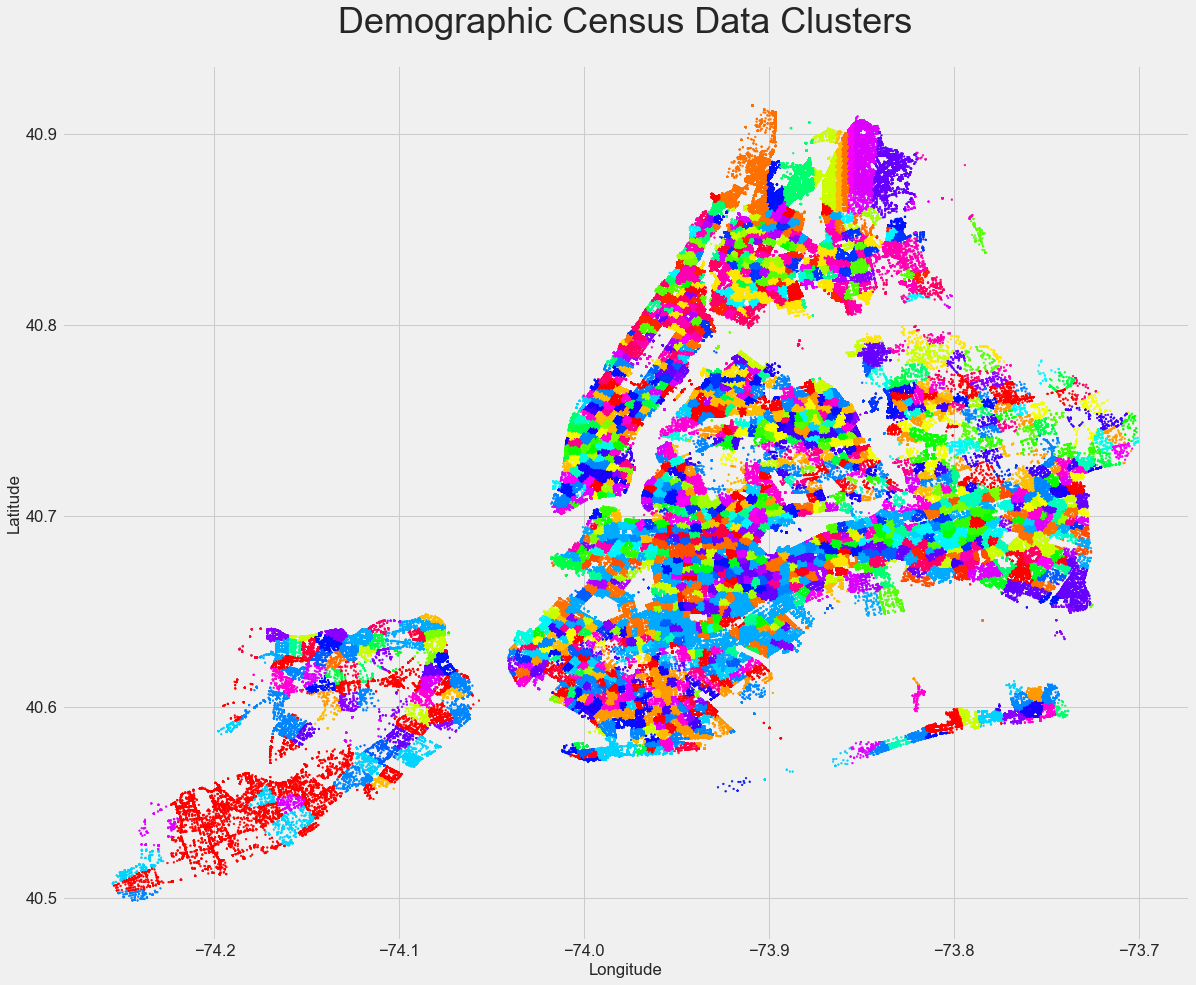

In [8]:
# asign clusters back as new column in arrests
arrests['demographics_cluster'] = km_demos.labels_
plt.figure(figsize=(18, 15))
plt.scatter(arrests.Longitude, arrests.Latitude, c=arrests['demographics_cluster'], s=3, cmap="hsv"); #'tab20'
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Demographic Census Data Clusters', fontsize=36, y=1.03);

---

In [9]:
econ = census[['CensusTract', 'IncomePerCap', 'PrivateWork', 'PublicWork', 'MeanCommute']]
econ = arrests[['CensusTract']].merge(econ, how='left', on='CensusTract')
econ = econ.drop(columns=['CensusTract'])

In [10]:
%%time
sc = StandardScaler()
D = demos
D_sc = sc.fit_transform(D)
km_demos = KMeans(n_clusters=clusters, random_state=42)
km_demos.fit(D_sc)

CPU times: user 3min 32s, sys: 44.8 s, total: 4min 17s
Wall time: 39.2 s


KMeans(n_clusters=40, random_state=42)

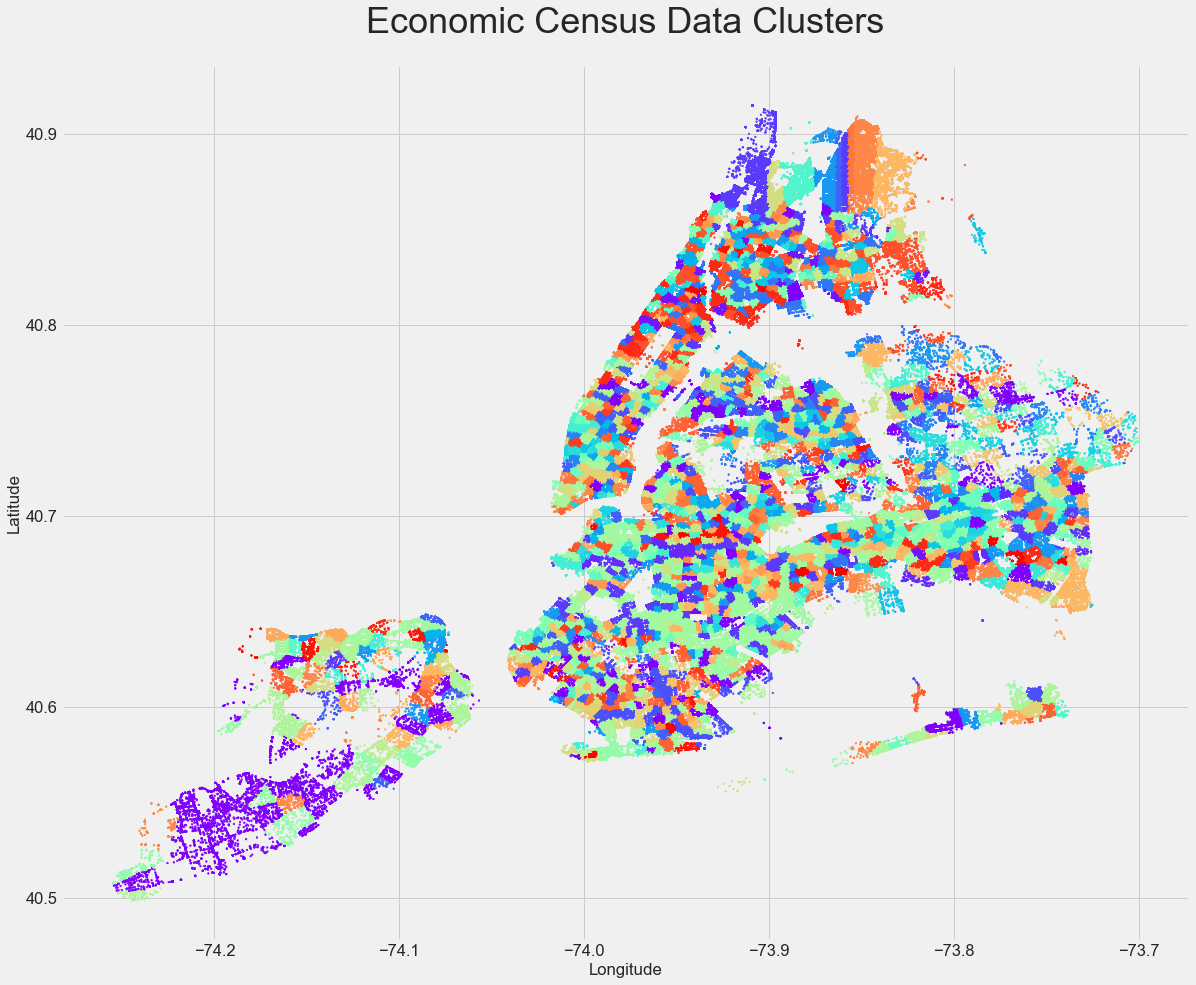

In [11]:
# asign clusters back as new column in arrests
arrests['economics_cluster'] = km_demos.labels_
plt.figure(figsize=(18, 15))
plt.scatter(arrests.Longitude, arrests.Latitude, c=arrests['economics_cluster'], s=3, cmap="rainbow"); #'tab20'
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Economic Census Data Clusters', fontsize=36, y=1.03);

---
## Preprocessing 
---

Creating some interaction terms 

In [12]:
arrests['pct_sq'] = arrests['ARREST_PRECINCT'] ** 2
arrests['pct_x_boro'] = arrests['ARREST_PRECINCT'] * arrests['ARREST_BORO']
arrests['pct_x_offense'] = arrests['ARREST_PRECINCT'] * arrests['alleged_offense']
arrests['pct_x_tract'] = arrests['ARREST_PRECINCT'] * arrests['CensusTract']
arrests['demo_x_econ'] = arrests['economics_cluster'] * arrests['demographics_cluster']
arrests['econ_x_offense'] = arrests['economics_cluster'] * arrests['alleged_offense']

Exporting for Next Steps: Neural Network modeling 

In [13]:
arrests.to_csv('./cleaned_datasets/clustered_arrests_for_nn_gridsearch.csv', index=False)

In [14]:
# dropping columns besides our target column as per the arrests EDA notebook
X = arrests.drop(columns=['PERP_RACE', 'X_COORD_CD', 'Y_COORD_CD','KY_CD', 'JURISDICTION_CODE'])
y = arrests.PERP_RACE

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y) 

ros = RandomOverSampler()
X_train_over, y_train_over = ros.fit_resample(X_train, y_train)

# smote = SMOTE()
# X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

---
## GridSearch
---

In [15]:
pipe = Pipeline([
    ("sc", StandardScaler()),
    
    ("pca", PCA(random_state=42)),
    
    ("vc", VotingClassifier([
          ('knc', KNeighborsClassifier()),
#           ('ext', RandomForestClassifier(random_state=42)),
          ('ext', ExtraTreesClassifier(random_state=42)),
                ],
                voting = 'soft')),
    ])

params = {
    'vc__weights': [[1, 4]], #[[3, 4]],#[[1, 2], [2, 3], [3, 4], [1, 1], [3, 2], [2, 1],],
    
    'pca__n_components': [
        X_train.shape[1], 
#         (X_train.shape[1]-1), 
#         (X_train.shape[1]-2), 
#         (X_train.shape[1]-3),
#         (X_train.shape[1]-4),
# #         (X_train.shape[1]-5)
    ],
    'pca__whiten': [True], #False, 
    
    'vc__ext__n_estimators': [130],
    'vc__ext__max_depth': [1_000],
    'vc__ext__min_samples_split': [4],
    'vc__ext__min_samples_leaf': [1],
    'vc__ext__max_features': ['auto'],
    'vc__ext__bootstrap': [True],

    'vc__knc__leaf_size':  [7], # np.linspace(1, 20, 7).astype(int),
    'vc__knc__n_neighbors': [30], # np.linspace(30, 70, 9).astype(int), 
    'vc__knc__weights': ['distance'], #  'uniform', 
}

gs = GridSearchCV(
    estimator=pipe,
    param_grid=params,
    cv=5,
    verbose=10,
    n_jobs=-1
    )

#### Without Oversampling
Because we're looking at arrests of Black and Hispanic people in NYC that are already disproportionally represented compared to the general population, most of our analysis of our model results are taken from a run of the model without oversampling; we were less concerned with misclassifications of white and Asian/Pacific Islander arrestees as they're already underrepresented in the arrest record compared to the general population. Results from running the model with random oversampling can be found below the Conclusions section

In [16]:
%%time 
without_oversampling = gs.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: user 2min 13s, sys: 3.61 s, total: 2min 17s
Wall time: 2h 12min 6s


In [18]:
print("Best Estimator:", without_oversampling.best_estimator_)
print("Best Parameters:", without_oversampling.best_params_)

Best Estimator: Pipeline(steps=[('sc', StandardScaler()),
                ('pca', PCA(n_components=16, random_state=42, whiten=True)),
                ('vc',
                 VotingClassifier(estimators=[('knc',
                                               KNeighborsClassifier(leaf_size=7,
                                                                    n_neighbors=30,
                                                                    weights='distance')),
                                              ('ext',
                                               ExtraTreesClassifier(bootstrap=True,
                                                                    max_depth=1000,
                                                                    min_samples_split=4,
                                                                    n_estimators=130,
                                                                    random_state=42))],
                                  voting='soft',

In [19]:
print("Train Score Without Oversampling:", without_oversampling.score(X_train, y_train))
print("Test Score Without Oversampling: ", without_oversampling.score(X_test, y_test))

Train Score Without Oversampling: 0.6948601971752925
Test Score Without Oversampling:  0.6577642132079832


In [20]:
print("F1 Score  Without Oversampling:  ", f1_score(y_test, without_oversampling.predict(X_test),
                                                  average='weighted'))

F1 Score  Without Oversampling:   0.6517885121683623


#### Model Performance

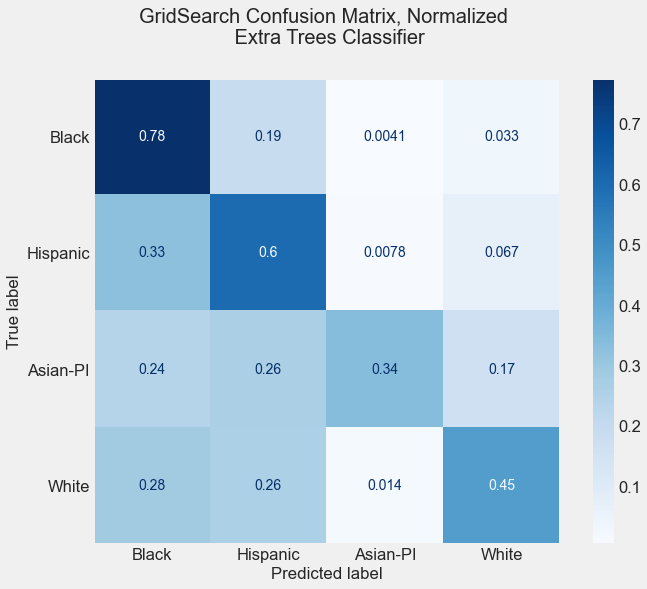

In [21]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_confusion_matrix(without_oversampling, X_test, y_test,
                     display_labels=['Black', 'Hispanic', 'Asian-PI', 'White'],
                     normalize='true', cmap='Blues', ax=ax)
plt.grid(False)
plt.title("GridSearch Confusion Matrix, Normalized \n Extra Trees Classifier", fontsize=20, y=1.06);

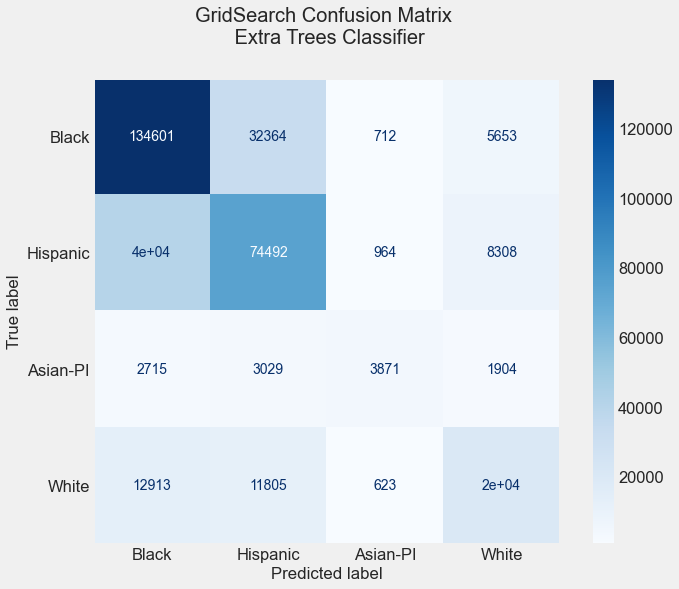

In [22]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_confusion_matrix(without_oversampling, X_test, y_test,
                     display_labels=['Black', 'Hispanic', 'Asian-PI', 'White'],
                     cmap='Blues', ax=ax)
plt.grid(False)
plt.title("GridSearch Confusion Matrix \n Extra Trees Classifier", fontsize=20, y=1.06);

The main misclassification was between Black and Hispanic arrestees, and while oversampling slightly improves the performance of the model with misclassifying white and Asian arrestees, it exacerbates the much more frequent conflation between Black and Hispanic

In [23]:
without_preds = without_oversampling.best_estimator_.predict(X)

In [24]:
nonviolent = ['MARIJUANA',  'MISCHIEF', 'PROSTITUTION', 'CONTROLLED SUBSTANCE', 'RESISTING ARREST', 
              'DISORDERLY CONDUCT', 'FORGERY,ETC.-MISD', 'DRUG PARAPHERNALIA', 
              'LOITERING', 'ASSEMBLY,UNLAWFUL', 'BAIL JUMPING', 'BURGLARS TOOLS,UNCLASSIFIED', 
              'POSSESSION HYPODERMIC INSTRUMENT', 'GAMBLING', 'PARKR&R,UNCLASSIFIED VIOLATION' ]
nv = {idx: charge for idx, charge in enumerate(nonviolent)}
nv

{0: 'MARIJUANA',
 1: 'MISCHIEF',
 2: 'PROSTITUTION',
 3: 'CONTROLLED SUBSTANCE',
 4: 'RESISTING ARREST',
 5: 'DISORDERLY CONDUCT',
 6: 'FORGERY,ETC.-MISD',
 7: 'DRUG PARAPHERNALIA',
 8: 'LOITERING',
 9: 'ASSEMBLY,UNLAWFUL',
 10: 'BAIL JUMPING',
 11: 'BURGLARS TOOLS,UNCLASSIFIED',
 12: 'POSSESSION HYPODERMIC INSTRUMENT',
 13: 'GAMBLING',
 14: 'PARKR&R,UNCLASSIFIED VIOLATION'}

#### Misclassifications by arrest description 
How well the model performed for each alleged nonviolent offense 

In [25]:
(arrests[arrests['PERP_RACE'] == without_preds]['alleged_offense'].map(nv).value_counts() / arrests['alleged_offense'].map(nv).value_counts()).sort_values(ascending=False)

ASSEMBLY,UNLAWFUL                   0.792793
GAMBLING                            0.786422
LOITERING                           0.719428
FORGERY,ETC.-MISD                   0.718045
RESISTING ARREST                    0.713430
DISORDERLY CONDUCT                  0.711179
DRUG PARAPHERNALIA                  0.708103
MARIJUANA                           0.702349
CONTROLLED SUBSTANCE                0.675881
PROSTITUTION                        0.663984
BURGLARS TOOLS,UNCLASSIFIED         0.658240
PARKR&R,UNCLASSIFIED VIOLATION      0.642328
MISCHIEF                            0.639558
BAIL JUMPING                        0.611719
POSSESSION HYPODERMIC INSTRUMENT    0.583272
Name: alleged_offense, dtype: float64

In [26]:
(arrests[arrests['PERP_RACE'] != without_preds]['alleged_offense'].map(nv).value_counts() / arrests['alleged_offense'].map(nv).value_counts()).sort_values(ascending=False)

POSSESSION HYPODERMIC INSTRUMENT    0.416728
BAIL JUMPING                        0.388281
MISCHIEF                            0.360442
PARKR&R,UNCLASSIFIED VIOLATION      0.357672
BURGLARS TOOLS,UNCLASSIFIED         0.341760
PROSTITUTION                        0.336016
CONTROLLED SUBSTANCE                0.324119
MARIJUANA                           0.297651
DRUG PARAPHERNALIA                  0.291897
DISORDERLY CONDUCT                  0.288821
RESISTING ARREST                    0.286570
FORGERY,ETC.-MISD                   0.281955
LOITERING                           0.280572
GAMBLING                            0.213578
ASSEMBLY,UNLAWFUL                   0.207207
Name: alleged_offense, dtype: float64

#### Misclassifications visualized 


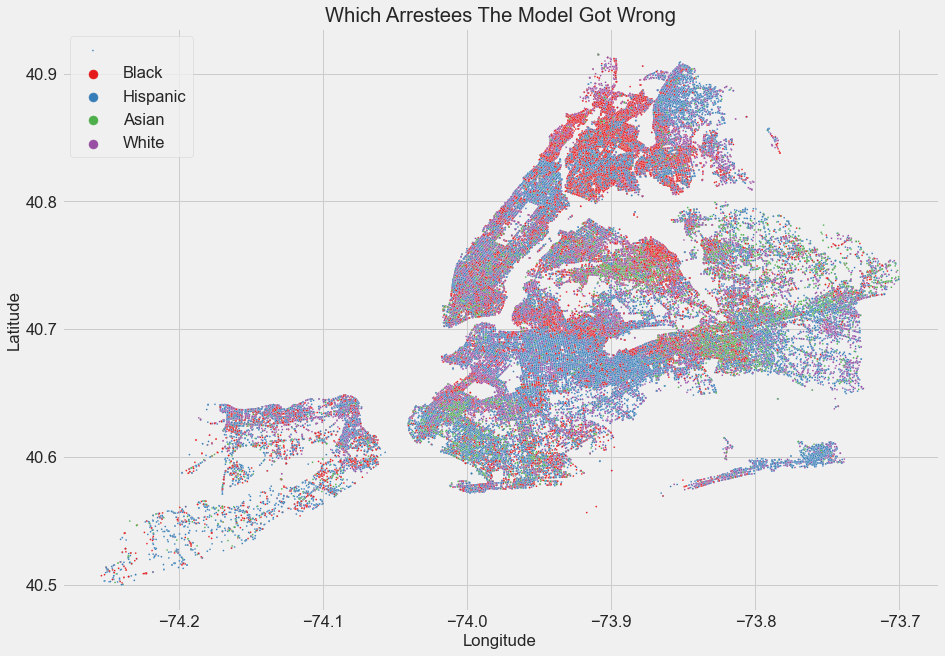

In [27]:
plt.figure(figsize=(14, 10))
sns.scatterplot(data=arrests[arrests['PERP_RACE'] != without_preds], hue='PERP_RACE', 
                palette='Set1',
            x='Longitude', y='Latitude', 
            s=3, alpha=1)
plt.legend(['', 'Black', 'Hispanic', 'Asian', 'White'], loc='upper left')        
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Which Arrestees The Model Got Wrong');

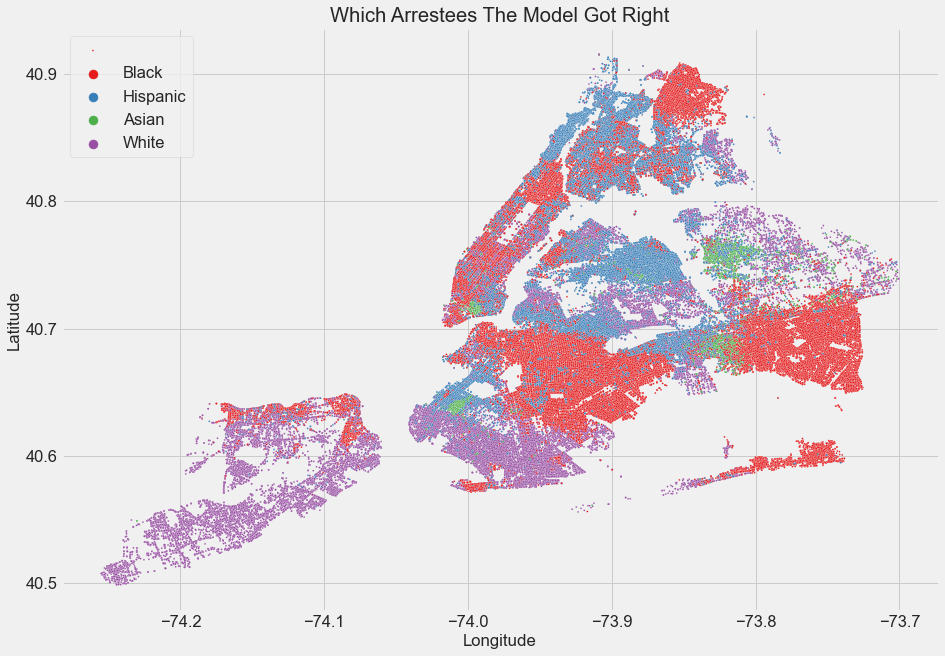

In [28]:
plt.figure(figsize=(14, 10))
sns.scatterplot(data=arrests[arrests['PERP_RACE'] == without_preds], hue='PERP_RACE', 
                palette='Set1',
            x='Longitude', y='Latitude', 
            s=3, alpha=1)
plt.legend(['', 'Black', 'Hispanic', 'Asian', 'White'], loc='upper left')        
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Which Arrestees The Model Got Right');

### Component models in the Voting Classifier 

In [29]:
ext = gs.best_estimator_.named_steps['vc'].named_estimators['ext'].fit(X_train, y_train)
knc = gs.best_estimator_.named_steps['vc'].named_estimators['knc'].fit(X_train, y_train)

In [30]:
%%time 
print('With Oversampling:')
print("Extra Trees Train Score:", ext.score(X_train_over, y_train_over))
print("Extra Trees Test Score: ", ext.score(X_test, y_test))
print()
print("KNeighbors Train Score:  ", knc.score(X_train_over, y_train_over))
print("KNeighbors Test Score:   ", knc.score(X_test, y_test))

With Oversampling:
Extra Trees Train Score: 0.7213887628176034
Extra Trees Test Score:  0.6634117335407472

KNeighbors Train Score:   0.4986533343077148
KNeighbors Test Score:    0.6301353263105686
CPU times: user 17h 38min 10s, sys: 8h 35min 12s, total: 1d 2h 13min 22s
Wall time: 13h 8min 19s


---
## Conclusions
---

That the limits on the ability to predict the race of an arrestee mostly falls to conflation between nonviolent Black and Hispanic arrestees illustrates a system that clearly practices greater restraint when it comes to the policing of white people while throwing the book at people of color 

Complaints against the NYPD show the same results as the arrests. Black and Hispanic people file complaints against the NYPD much more than white, indigenous or asian people and the complaints filed by people of color are generally based on physical force as opposed to verbal assault

---
## With Oversampling
---

In [31]:
%%time
with_oversampling = gs.fit(X_train_over, y_train_over)
# print("Best Estimator:", with_oversampling.best_estimator_)
# print("Best Parameters:", with_oversampling.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: user 4min 34s, sys: 5.79 s, total: 4min 40s
Wall time: 8h 54min 49s


In [ ]:
%%time 
print("Train Score With Oversampling:", with_oversampling.best_estimator_.score(X_train_over, y_train_over))
print("Test Score With Oversampling:", with_oversampling.best_estimator_.score(X_test, y_test))

In [ ]:
print("PCA Explained Variance:", gs.best_estimator_.named_steps['pca'].explained_variance_ratio_)
print()
print("Sum Explained Variance:", gs.best_estimator_.named_steps['pca'].explained_variance_ratio_.sum())

---

Below is a look at the probabilities of the model's predictions adjusted for the census demographics for the Census Tract the arrest happened nearest to. This would be a more useful tool with a more performant model, but as is still shows a pretty distinct disparity  especially for areas like Manhattan where few people of color live. It shows that arrestees are more likely to be Black or Hispanic at a rate at or below the demographic makeup of the area the arrest happened in, while white arrestees tend to be at or below the background demographics of an area  

In [ ]:
census = pd.read_csv('./cleaned_datasets//cleaned_census_data.csv', index_col=0)
census = census.drop(columns = ['Latitude', 'Longitude'])

map_demos = {'Black': 0, 'Hispanic': 1, 'Asian': 2, 'White': 3}

for i in map_demos:
    arrests[f'arrestee_prob_{i.lower()}'] = pd.DataFrame(without_preds)[map_demos[i]]
# arrests['arrestee_prob_black'] = pd.DataFrame(without_preds)[0]
# # arrests['arrestee_prob_white'] = pd.DataFrame(without_preds)[4]
# arrests['arrestee_prob_white'] = pd.DataFrame(without_preds)[3]

arrests_census = arrests.merge(census, how='inner', on='CensusTract')

for i in map_demos:
    arrests_census[f'adj_arrestee_prob_{i.lower()}'] = arrests_census[f'arrestee_prob_{i.lower()}'] - (arrests_census[i]/100)
# arrests_census['adj_arrestee_prob_black'] = arrests_census['arrestee_prob_black'] - (arrests_census['Black']/100)
# arrests_census['adj_arrestee_prob_white'] = arrests_census['arrestee_prob_white'] - (arrests_census['White']/100)

In [ ]:
arrests_census.plot(kind='scatter', x='Longitude', y='Latitude', c='adj_arrestee_prob_black', 
                   cmap="rocket_r", figsize=(14, 10), s=2, legend=True, 
                   title='Probability Arrestee is Black, \n Compared for Census Tract Demographics');

In [ ]:
arrests_census.plot(kind='scatter', x='Longitude', y='Latitude', c='adj_arrestee_prob_white', 
                   cmap="rocket_r", figsize=(14, 10), s=2, legend=True, 
                   title='Probability Arrestee is White, \n Compared for Census Tract Demographics');